# <center> Compressed Bert Model

This model is a reduced BERT model that is trained differently. Though the ReducedBERT model performs well on the GLUE tasks when compared to the full-size BERT model, it has some limitations. 

1. The embeddings from the ReducedBERT model did not cluster well. Where a set of full-sized embeddings originally clustered into around 250 different groups, the reduced embeddings were clustered into only 2-3 groups. Adding some dimensionality reduction to the already reduced embeddings resulted in more clusters, but the clustering did not appear to be meaningful.
2. Intuitively, while training the ReducedBERT reduction head on language understanding may be helpful, the base BERT model has already been trained for language understanding. Since we freeze the BERT weights anyway, we should focus on training our model head for reduction instead of MLM and NSP, trusting that the understanding from BERT will be transferred to the reduced embeddings.

Our new model proposes adding both a contrastive learning objective and a reconstruction objective to our previous ReducedBERT model in place of the MLM and NSP model heads. These new objectives are designed to preserve to structure of the BERT embedding space while retaining the information present in the full-size BERT embeddings, effectively helping the embeddings cluster better. 

For contrastive learning, the idea is to push items that are similar together, and push items that are different apart from each other in the reduced embedding space. While this would be a potentially difficult problem with unlabeled text, we have the advantage of having the original BERT embeddings to compare against. Thus, for our contrastive loss, we get the cosine similarity between all pairs of original BERT embeddings in a training batch, and then compare those similarities against the cosine similarities of pairs of the corresponding reduced embeddings. We then push the consine similarities of the reduced embeddings to match the consine similarities of the original embeddings using an MSE loss. This essentially teaches the reduction head to keep the structure of the original embedding space in the reduced embedding space.

For the reconstruction objective, we add a set of decompression layers to the end of the model into order to extract information from the reduced embeddings and recreate the full-size embeddings. We compare these reconstructed embeddings to the true full-size BERT embeddings and apply an MSE loss to try to get the reconstruction as close to the original as possible. This also teaches the reduction heads to reduce the full-size embeddings in such a way where the reduced embeddings contain all the same information as the full-size embeddings.

In [1]:
# TODO: Test the intermediate reduction layer embeddings to see how they perform on GLUE tasks compared to the fully reduced model.
# TODO: Determine how to train such that clusters are better
#    - Maybe try using self-supervised contrastive learning, where the full-size embeddings are used as a baseline. (https://encord.com/blog/guide-to-contrastive-learning/#:~:text=NLP%20deals%20with%20the%20processing,semantic%20information%20and%20contextual%20relationships.)
#    - Check out the papers here (https://github.com/ryanzhumich/Contrastive-Learning-NLP-Papers?tab=readme-ov-file#4-contrastive-learning-for-nlp)
# TODO: Check if its best to train the first reduction layer first, then the second, etc., freezing the previous layers as you go.

# TODO: Fix defaults from BertReducedConfig in the BertReducedForPreTraining class (and potentially other model classes).

## Multi-Objective Learning (Contrastive vs Reconstruction loss)

Note that we are using two loss values, the contrastive and the reconstruction loss, and these two loss values are not on the same scale. Thus, to get a good total loss value, we add parameters--contrastive_weight and reconstruction_weight--to the model to get an appropriate total loss value. These parameters are set to 0.5 by default, but as the model is trained, the loss weights are learned to minimize the homoscedastic uncertainty of the model, as outlined in [this paper](https://arxiv.org/pdf/1705.07115.pdf).

From the paper, we get our loss equation:

\begin{equation}
    \mathcal{L} = \frac{1}{2\sigma_1^2} \mathcal{L}_1 + \frac{1}{2\sigma_2^2} \mathcal{L}_2 + \log(\sigma_1\sigma_2)
\end{equation}

We rewrite the above for numerical stability and better interpretability, setting $\alpha = \frac{1}{2\sigma_1^2}$ to be our contrastive loss weight, and $\beta = \frac{1}{2\sigma_2^2}$ to be our reconstruction loss weight. Thus, our final loss function is given by the following equation:

\begin{equation}
    \mathcal{L}_{total} = \alpha \mathcal{L}_{contrastive} + \beta \mathcal{L}_{reconstruction} - \frac{1}{2}\log(\alpha\beta)
\end{equation}

where $\alpha$ and $\beta$ are the learned contrastive and reconstruction weights, respectively.

## Load the Pretrained CompresSBERT model

To train the model, we started with the weights from the MPNet sentence-transformers model, which is a BERT-based model trained on a large corpus of text. We then added the reduction head, contrastive loss, and reconstruction loss to the model. The model was trained on the wikipedia dataset, and the weights were saved to the HuggingFace model hub.

In [1]:
from transformers import AutoConfig, AutoTokenizer, AutoModelForPreTraining, AutoModel
import reduced_encoders     # This registers the compressed models with the AutoModel classes

checkpoint = "cayjobla/all-mpnet-base-v2-compressed"
config = AutoConfig.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
pretrain = AutoModelForPreTraining.from_pretrained(checkpoint, config=config)
model = AutoModel.from_pretrained(checkpoint, config=config)

/home/cayjobla/miniconda3/envs/reduced_encoders/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetCompressedForPreTraining were not initialized from the model checkpoint at cayjobla/all-mpnet-base-v2-compressed and are newly initialized: ['expand.0.dense.bias', 'expand.0.dense.weight', 'expand.0.layernorm.bias', 'expand.0.layernorm.weight', 'expand.1.dense.bias', 'expand.1.dense.weight', 'expand.1.layernorm.bias', 'expand.1.layernorm.weight', 'expand.2.dense.bias', 'expand.2.dense.weight', 'expand.2.layernorm.bias', 'expand.2.layernorm.weight', 'expand.3.dense.bias', 'expand.3.dense.weight', 'expand.3.layernorm.bias', 'expand.3.layernorm.weight', 'expand.4.dense.bias', 'expand.4.dense.weight', 'expand.4.layernorm.bias', 'expand.4.layernorm.weight

In [2]:
config

MPNetReducedConfig {
  "_name_or_path": "cayjobla/all-mpnet-base-v2-compressed",
  "architectures": [
    "MPNetCompressedForPretraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet_reduced",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "pooling_mode": "mean",
  "reduced_size": 48,
  "reduction_sizes": [
    512,
    256,
    128,
    64,
    48
  ],
  "relative_attention_num_buckets": 32,
  "torch_dtype": "float32",
  "transformers_version": "4.40.2",
  "vocab_size": 30527
}

In [3]:
pretrain

MPNetCompressedForPreTraining(
  (mpnet): MPNetModel(
    (embeddings): MPNetEmbeddings(
      (word_embeddings): Embedding(30527, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): MPNetEncoder(
      (layer): ModuleList(
        (0-11): 12 x MPNetLayer(
          (attention): MPNetAttention(
            (attn): MPNetSelfAttention(
              (q): Linear(in_features=768, out_features=768, bias=True)
              (k): Linear(in_features=768, out_features=768, bias=True)
              (v): Linear(in_features=768, out_features=768, bias=True)
              (o): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

## Preliminary Testing

We quickly check the pretrained model against our intuition on a few example sentences.

In [4]:
text = ['This is a test sentence that is meant to determine whether I can run text through my new compressed SBERT model. Did it work?',
        'This is also a test sentence, but it is different from the first one. I hope this works!',
        'A feral cat walked down the street, hoping to find a place to rest for the night',
        'The last sentence was significantly different from the others to see where the embedding lands']

In [5]:
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

In [7]:
import torch

with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
outputs.last_hidden_state.shape

In [18]:
from reduced_encoders.modeling_utils import get_cos_sim

# Get the cosine similarity between the sentences
# Format is (1,2), (1,3), (1,4), (2,3), (2,4), (3,4)
get_cos_sim(outputs.last_hidden_state)

tensor([0.3882, 0.0505, 0.3176, 0.0998, 0.6617, 0.0136])

Thus, as we expect, the third of the four sentences was the least like the other 3 sentences, and we are still able to get that result with the reduced embeddings.

In [22]:
# Compare to the original BERT embeddings
outputs.unreduced_pooler_output.shape

torch.Size([4, 768])

In [23]:
get_cos_sim(outputs.unreduced_pooler_output)

tensor([0.4352, 0.0172, 0.3200, 0.0596, 0.3839, 0.0697])

It seems like the full-size embeddings are somewhat similar to the similarities of the reduced embeddings, which is good.

In [27]:
# Compare to the reconstructed embeddings
reconstructed = model.expand(outputs.last_hidden_state)
reconstructed.shape

torch.Size([4, 768])

In [28]:
get_cos_sim(reconstructed)

tensor([0.4786, 0.0754, 0.4968, 0.2124, 0.8201, 0.2510],
       grad_fn=<IndexBackward0>)

There are some significant differences between the reconstructed embedding similarities and the other embedding similarities, but the similarities still follow a similar pattern. 

I wonder if the model needs more variety in its training data in order to know how to reduce and reconstruct different types of text. I also wonder if the model needs to be trained for more epochs in order to get better results.

## GLUE tasks

| Task   | Score                                     |
| ------ | ----------------------------------------- |
| COLA   | 0.5418 (matthew's corr.)                  |
| MNLI   | 0.8732 (acc)                              |
| MRPC   | 0.8529/0.894/0.8735 (acc/f1/combined)     |
| QNLI   | 0.9231 (acc)                              |
| QQP    | 0.9157/0.8876/0.9017 (acc/f1/combined)    |
| RTE    | 0.6606 (acc)                              |
| SST2   | 0.9484 (acc)                              |
| STSB   | 0.8937 (spearman)                         |
| WNLI   | 0.5634 (acc)                              |

## Clustering and Topic Modeling

In [1]:
from transformers import AutoTokenizer, AutoModel
import reduced_encoders

import torch
from tqdm import tqdm
from hdbscan import HDBSCAN
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

class BERTopicReduced():
    def __init__(self, model=None, tokenizer=None, clustering_method=None, device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        default_model = "cayjobla/all-mpnet-base-v2-compressed"

        self.model = model or default_model
        if type(self.model) == str:
            default_model = self.model  # So that tokenizer matches model by default
            self.model = AutoModel.from_pretrained(self.model)
        self.model.to(self.device)

        self.tokenizer = tokenizer or default_model
        if type(self.tokenizer) == str:
            self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer)

        self.clustering_method = clustering_method or HDBSCAN(min_cluster_size=10, 
                                                                metric='euclidean', 
                                                                cluster_selection_method='eom')
        self.embeddings = None

    def batch(self, data, batch_size=16):
        for i in range(0, len(data), batch_size):
            yield data[i:i+batch_size]
            
    def embed(self, text, batch_size=16):
        embeddings = []
        progress_bar = tqdm(total=len(text), desc="Embedding text", position=0)

        p_bar = tqdm(range(len(text)), desc="Embedding text", leave=False)
        for batch in self.batch(text, batch_size=batch_size):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(self.device)
            outputs = self.model(**inputs)
            embeddings += [*outputs[0].cpu().detach().numpy()]
            progress_bar.update(len(batch))
        progress_bar.close()

        self.embeddings = np.array(embeddings)
        return self

    def cluster(self, clustering_method=None, max_iter=100):
        if clustering_method is not None:
            self.clustering_method = clustering_method
        if self.embeddings is None:
            raise ValueError("Please embed the data first using the embed() method.")
        clusters = self.clustering_method.fit(self.embeddings)
        self.labels = clusters.labels_
        self.num_clusters = len(set(self.labels))
        return self

    def get_topics(self, text):
        raise NotImplementedError("This method is not implemented yet")

    def fit(self, text, batch_size=16, max_iter=1000):
        self.embed(text, batch_size=batch_size)
        self.cluster(max_iter=max_iter)
        return self

In [2]:
from reduced_encoders import MPNetCompressedModel, MPNetReducedConfig

# config = MPNetReducedConfig.from_pretrained("cayjobla/all-mpnet-base-v2-compressed", revision="variable", reduction_sizes=[512])
# model = MPNetCompressedModel.from_pretrained("cayjobla/all-mpnet-base-v2-compressed", revision="variable", config=config)
model = AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

reduced_topic_model = BERTopicReduced(
    model=model
)

/home/cayjobla/miniconda3/envs/reduced_encoders/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups()
documents = newsgroups.data

In [4]:
reduced_topic_model.embed(documents)
reduced_topic_model.embeddings.shape

Embedding text: 100%|██████████| 11314/11314 [01:58<00:00, 95.64it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (11314,) + inhomogeneous part.

In [ ]:
reduced_topic_model.cluster()
labels, counts = np.unique(reduced_topic_model.labels, return_counts=True)
print("Labels:", labels)
print("Counts:", counts)

Labels: [-1  0  1]
Counts: [2256 9043   15]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import pandas as pd

def visualize_space_2d(embeddings_2d, labels):
    """Plot the distribution of embedding vectors projected to 2 dimensions using PCA."""
    df_emb = pd.DataFrame(embeddings_2d, columns=["X", "Y"])
    df_emb["label"] = labels

    # Plot
    num_labels = len(np.unique(labels))
    colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C8", "C9"]
    for i, label in enumerate(np.unique(labels)):
        color = "C7" if label == -1 else colors[i%len(colors)]
        df_emb_sub = df_emb.query(f"label == {label}")
        plt.scatter(df_emb_sub["X"], df_emb_sub["Y"], c=color, alpha=0.1)
        plt.gca().set_aspect('equal', 'box')
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca_embeddings_2d = PCA(n_components=2).fit_transform(reduced_topic_model.embeddings)
visualize_space_2d(pca_embeddings_2d, reduced_topic_model.labels)

In [ ]:
from umap import UMAP

umap_embeddings_2d = UMAP().fit_transform(reduced_topic_model.embeddings)
visualize_space_2d(umap_embeddings_2d, reduced_topic_model.labels)

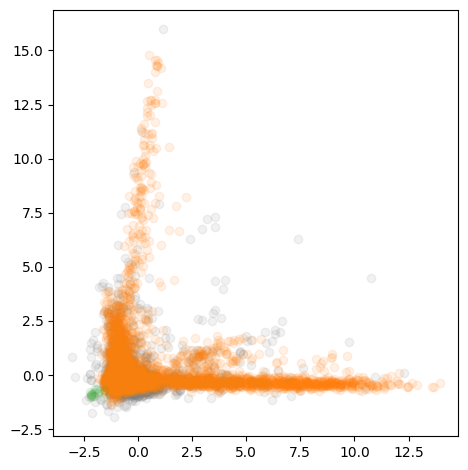

In [42]:
from sklearn.decomposition import PCA

pca_embeddings_2d = PCA(n_components=2).fit_transform(reduced_topic_model.embeddings)
visualize_space_2d(pca_embeddings_2d, reduced_topic_model.labels)

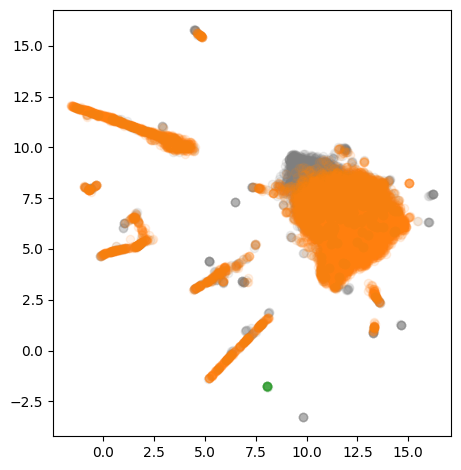

In [43]:
from umap import UMAP

umap_embeddings_2d = UMAP().fit_transform(reduced_topic_model.embeddings)
visualize_space_2d(umap_embeddings_2d, reduced_topic_model.labels)

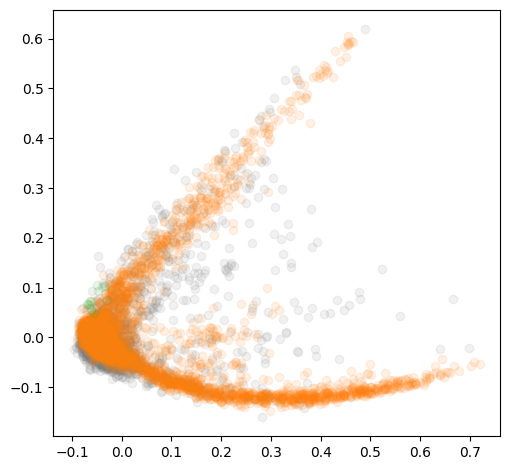

In [ ]:
from sklearn.decomposition import PCA

pca_embeddings_2d = PCA(n_components=2).fit_transform(reduced_topic_model.embeddings)
visualize_space_2d(pca_embeddings_2d, reduced_topic_model.labels)

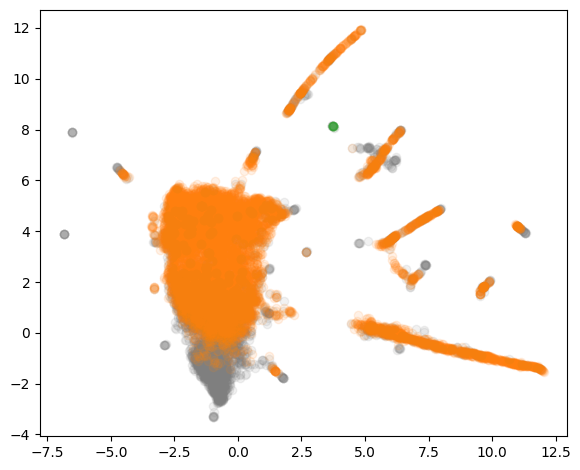

In [ ]:
from umap import UMAP

umap_embeddings_2d = UMAP().fit_transform(reduced_topic_model.embeddings)
visualize_space_2d(umap_embeddings_2d, reduced_topic_model.labels)